## Imports

In [1]:
from torchvision import transforms
from tqdm.notebook import trange

# from custom files
from dataset import CompCarsImageFolder, WrapperDataset, ImagesFromTextFile
from models import ResNet, resnet_cfg
from models import train, validate
from utils import *

## Configuration

In [2]:
###### Set root to the image folder of CompCars dataset ######

#TODO: ADAPT TO YOUR FOLDER STRUCTURE

# EDO'S PATHS
root = '/Volumes/EDO/NNDL/CompCars dataset/data/image/'
train_file = '/Volumes/EDO/NNDL/CompCars dataset/data/train_test_split/classification/train.txt'
test_file = '/Volumes/EDO/NNDL/CompCars dataset/data/train_test_split/classification/test.txt'

# DEFAULT PATHS
#root = '../cars_data/data/image/'
#train_file = '../cars_data/data/train_test_split/classification/train.txt'
#test_file = '../cars_data/data/train_test_split/classification/test.txt'

#############################################################

### Hyperparam configuration # TODO: TUNE

resnet_type = 'resnet18'                # 'resnet18', 'resnet34', 'resnet50'    

params = {                              ## Training Params (inspired from original resnet paper: https://arxiv.org/pdf/1512.03385)
    'epoch_num': 50,                    # number of epochs
    'lr': 1e-1,                         # (initial) Learning Rate
    'weight_decay': 1e-4,               # L2 Penalty
    'batch_size': 128,                   # batch size (depends on hardware)
    'momentum': 0.9,
    
    'hierarchy': 1,                     # Choose 0 for manufacturer classification, 1 for model classification
    'val_split': 10000,                 # (float) Fraction of validation holdout / (int) Absolute number of data points in holdout
    
    'resnet': resnet_cfg[resnet_type],  # ResNet configuration

    'use_train_test_split': False       # True: use prepared split, False: use total dataset
}

### Device
if torch.cuda.is_available():
    params["device"] = torch.device("cuda")   # option for NVIDIA GPUs
elif torch.backends.mps.is_available():
    params["device"] = torch.device("mps")    # option for Mac M-series chips (GPUs)
else:
    params["device"] = torch.device("cpu")    # default option if none of the above devices are available

print("Device: {}".format(params["device"]))

Device: mps


# Data Pipeline (prepared train-test-split)

## Read train/test text files separately

In [3]:
### Load prepared train_test_split
train_set = ImagesFromTextFile(root, txt_file=train_file, hierarchy=params['hierarchy'])
print(train_set.classes)
print(len(train_set.classes))

test_set = ImagesFromTextFile(root, txt_file=test_file, hierarchy=params['hierarchy'])
print(test_set.classes)
print(len(test_set.classes))

['100/211', '100/212', '100/213', '100/249', '100/250', '100/251', '100/252', '102/254', '102/255', '102/256', '102/257', '102/258', '102/259', '102/260', '102/261', '102/262', '102/263', '102/266', '102/267', '102/268', '102/269', '102/293', '103/1842', '103/1843', '103/1845', '105/294', '105/296', '105/297', '105/298', '105/302', '105/303', '105/304', '106/1313', '108/1516', '108/1521', '108/1526', '108/1528', '108/1530', '108/1531', '108/1543', '11/735', '11/736', '11/738', '111/1701', '111/1702', '111/1703', '111/1704', '111/1705', '111/1706', '111/1707', '111/1719', '111/1720', '111/1721', '111/1722', '114/1441', '114/1443', '114/1444', '114/1445', '114/1446', '114/1447', '114/1448', '114/1450', '118/1004', '118/955', '118/956', '118/957', '118/958', '118/959', '118/960', '118/961', '118/962', '118/963', '118/964', '118/968', '118/976', '118/980', '119/1819', '120/1691', '121/671', '122/586', '122/587', '122/588', '122/589', '122/590', '122/591', '122/593', '122/595', '122/597', '

## Raw Data Visualization

Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (909, 627)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (904, 623)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)


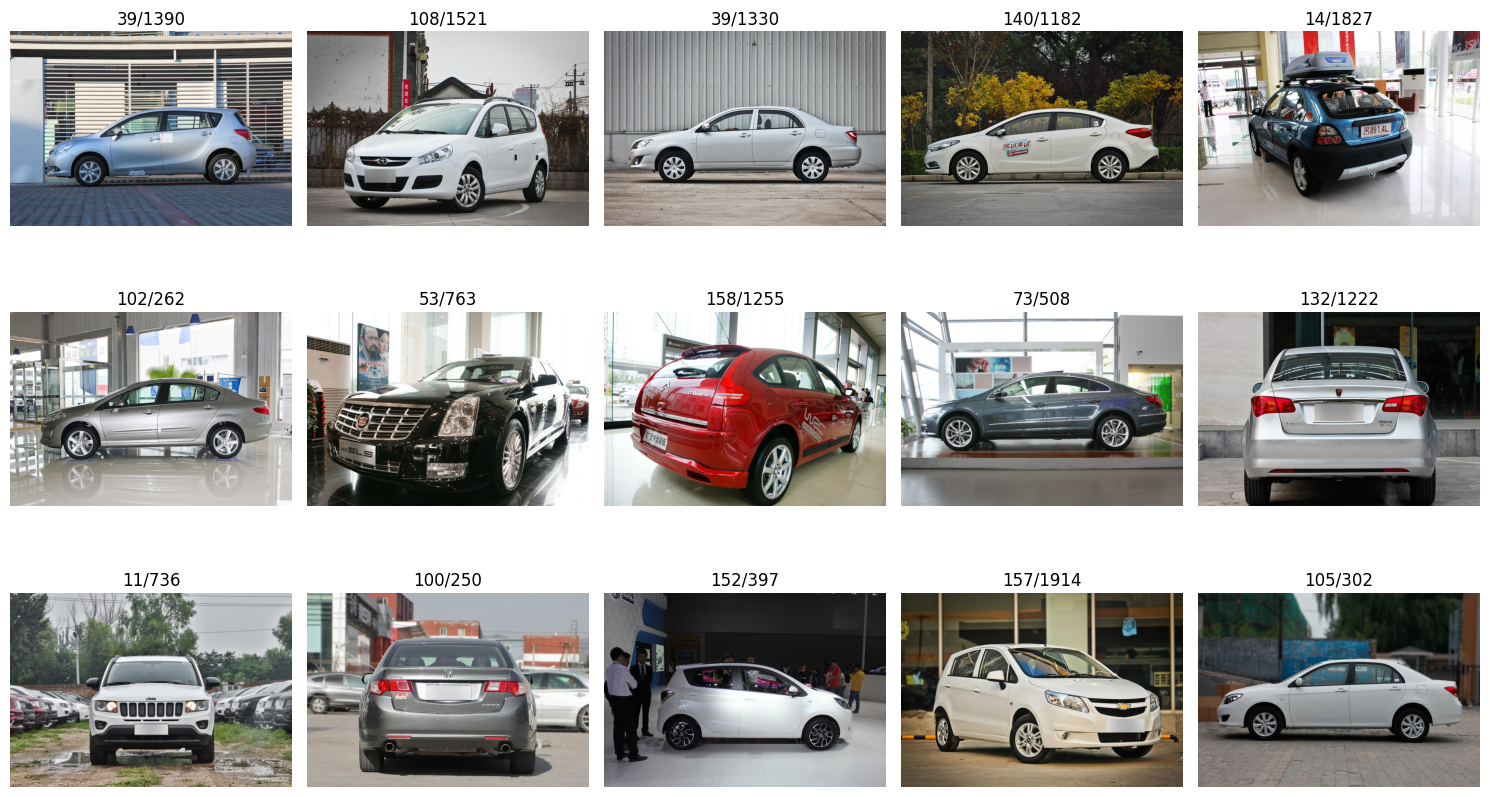

In [4]:
# Visualization of the train dataset
label_dict = {y: x for x, y in train_set.class_to_idx.items()}

num_images_to_show = 15
data_idx = np.random.randint(0, high=len(train_set), size=num_images_to_show)
num_cols = 5
num_rows = num_images_to_show // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()
for i in range(num_images_to_show):
    image, label = train_set[data_idx[i]]
    np_img = np.array(image)
    axes[i].imshow(np_img)
    axes[i].set_title(label_dict[label])
    axes[i].axis('off')
    print(f"Image shape: {image.size}")
plt.tight_layout()
plt.show()

# Data Pipeline (full data set)

## Read total Dataset

In [5]:
### Load full dataset
# hierarchy=0 -> manufacturer classification; hierarchy=1 -> model classification
total_set = CompCarsImageFolder(root, hierarchy=params['hierarchy'])
print(total_set.classes)
print(len(total_set.classes))


['1/1101', '1/1102', '1/1103', '1/1104', '1/1105', '1/1106', '1/1107', '1/1108', '1/1109', '1/1110', '1/1112', '1/1113', '10/1309', '100/209', '100/210', '100/211', '100/212', '100/213', '100/214', '100/215', '100/216', '100/217', '100/218', '100/219', '100/221', '100/222', '100/223', '100/226', '100/227', '100/228', '100/229', '100/230', '100/231', '100/232', '100/233', '100/234', '100/235', '100/236', '100/239', '100/240', '100/241', '100/242', '100/243', '100/247', '100/248', '100/249', '100/250', '100/251', '100/252', '101/816', '101/817', '101/818', '101/819', '101/820', '101/821', '102/253', '102/254', '102/255', '102/256', '102/257', '102/258', '102/259', '102/260', '102/261', '102/262', '102/263', '102/265', '102/266', '102/267', '102/268', '102/269', '102/271', '102/272', '102/273', '102/280', '102/281', '102/282', '102/283', '102/284', '102/285', '102/286', '102/287', '102/288', '102/289', '102/290', '102/291', '102/292', '102/293', '103/1842', '103/1843', '103/1844', '103/18

## Raw Data Visualization

Image shape: (800, 552)
Image shape: (800, 567)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (800, 567)
Image shape: (800, 418)
Image shape: (800, 552)
Image shape: (908, 626)
Image shape: (800, 552)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (908, 626)
Image shape: (800, 552)
Image shape: (800, 567)
Image shape: (800, 552)


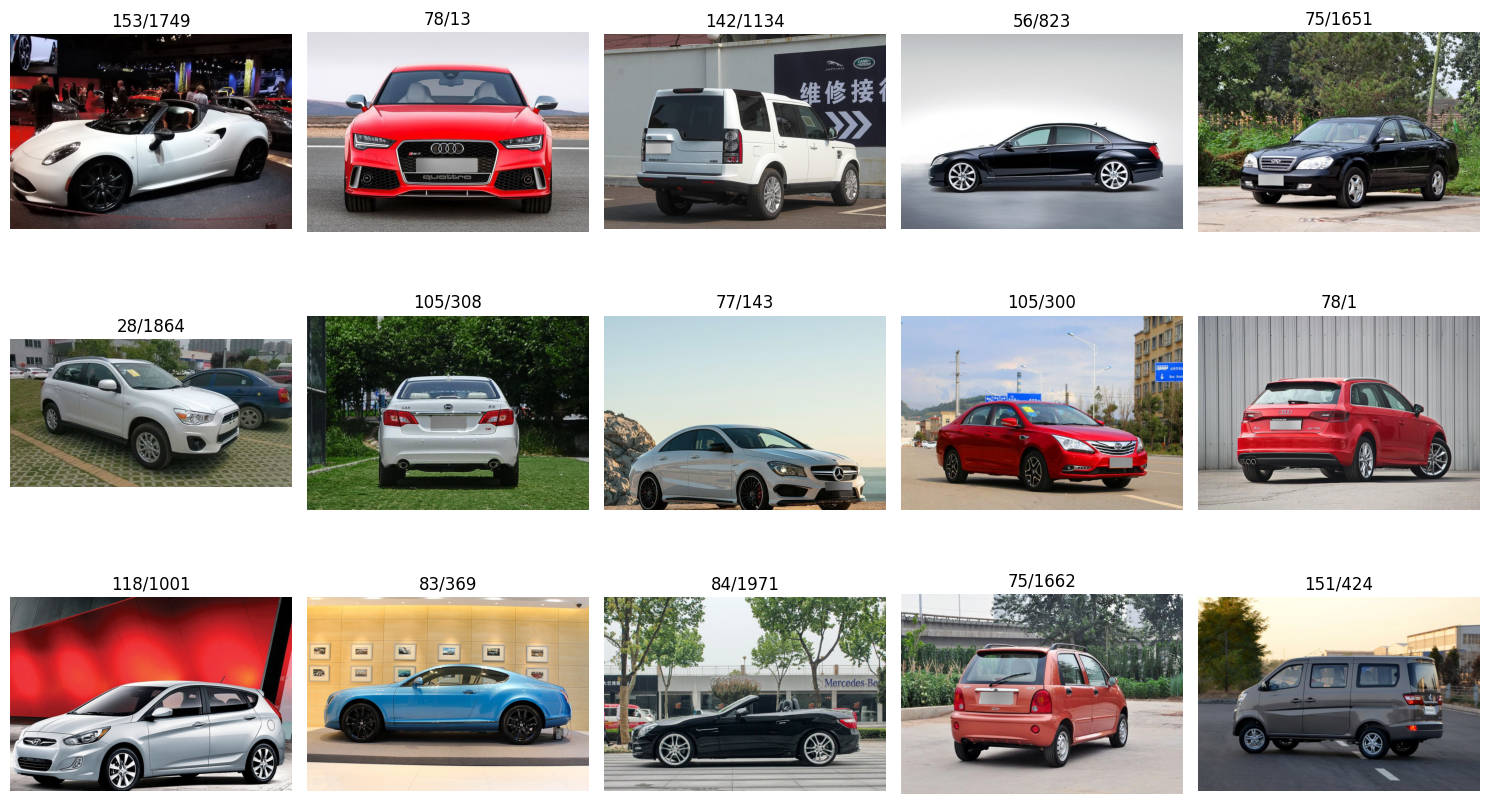

In [6]:
# Visualization of the dataset
label_dict = {y: x for x, y in total_set.class_to_idx.items()}

num_images_to_show = 15
data_idx = np.random.randint(0, high=len(total_set), size=num_images_to_show)
num_cols = 5
num_rows = num_images_to_show // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()
for i in range(num_images_to_show):
    image, label = total_set[data_idx[i]]
    np_img = np.array(image)
    axes[i].imshow(np_img)
    axes[i].set_title(label_dict[label])
    axes[i].axis('off')
    print(f"Image shape: {image.size}")
plt.tight_layout()
plt.show()

## Split in training and validation data

In [7]:
datasets = train_val_dataset(total_set, val_split=params['val_split'])

## Compute normalization statistics

In [8]:
'''
NOTE: This cell takes some time. Could be accelerated by:
    1. Using dataloader (vectorized batches)
    2. Resize images before computing statistics
'''
if params['use_train_test_split']:
    # resulting values from the lines below
    train_mean, train_std = [0.4913, 0.4796, 0.4696], [0.2873, 0.2860, 0.2914]
    val_mean, val_std = [0.4919, 0.4797, 0.4693], [0.2879, 0.2869, 0.2923]

    # Compute mean and std for training dataset
    # train_mean, train_std = compute_mean_std_from_dataset(train_set)
    # print(f"Training dataset mean: {train_mean}")
    # print(f"Training dataset std: {train_std}")

    # Compute mean and std for validation dataset
    # val_mean, val_std = compute_mean_std_from_dataset(test_set)
    # print(f"Validation dataset mean: {val_mean}")
    # print(f"Validation dataset std: {val_std}")
    
else:
    # default (computed statistic on whole dataset)
    mean, std = [0.483, 0.471, 0.463], [0.297, 0.296, 0.302]

    # Compute mean and std for training dataset
    # train_mean, train_std = compute_mean_std_from_dataset(datasets['train'])
    # print(f"Training dataset mean: {train_mean}")
    # print(f"Training dataset std: {train_std}")
    train_mean, train_std = mean, std

    # Compute mean and std for validation dataset
    # val_mean, val_std = compute_mean_std_from_dataset(datasets['val'])
    # print(f"Validation dataset mean: {val_mean}")
    # print(f"Validation dataset std: {val_std}")
    val_mean, val_std = mean, std

## Transform data - Prepare DataLoaders

In [9]:
# Apply transformation
########################## Transforms ############################
# TODO: Adapt transforms to our data set
# TODO: maybe use v2 transforms: https://pytorch.org/vision/stable/transforms.html

# inspired from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
data_transforms = { # TODO: TUNE
    'train': transforms.Compose([
        transforms.RandomChoice([
            transforms.Resize(256),
            transforms.Resize(224),
            transforms.Resize(320)
        ]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(224),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(val_mean, val_std)
    ])
}
##################################################################

if params['use_train_test_split']:
    wrapped_datasets = {
        'train': WrapperDataset(train_set, transform=data_transforms['train']),
        'val': WrapperDataset(test_set, transform=data_transforms['val'])
    }
else:
    wrapped_datasets = {
        'train': WrapperDataset(datasets['train'], transform=data_transforms['train']),
        'val': WrapperDataset(datasets['val'], transform=data_transforms['val'])
    }

dataloaders = {
    'train': DataLoader(wrapped_datasets['train'], batch_size=params['batch_size'], shuffle=True, num_workers=4),
    'val': DataLoader(wrapped_datasets['val'], batch_size=params['batch_size'], shuffle=False, num_workers=4)
}


print(f"Training dataset size: {len(wrapped_datasets['train'])}")
print(f"Validation dataset size: {len(wrapped_datasets['val'])}")

x, y = next(iter(dataloaders['train']))
print(f"Batch of training images shape: {x.shape}")
print(f"Batch of training labels shape: {y.shape}")

x, y = next(iter(dataloaders['val']))
print(f"Batch of validation images shape: {x.shape}")
print(f"Batch of validation labels shape: {y.shape}")

Training dataset size: 126726
Validation dataset size: 10000
Batch of training images shape: torch.Size([128, 3, 224, 224])
Batch of training labels shape: torch.Size([128])
Batch of validation images shape: torch.Size([128, 3, 224, 224])
Batch of validation labels shape: torch.Size([128])


# Training

## Set-Up

In [10]:
# Set up resnet model
resnet = ResNet(params['resnet']['block'], params['resnet']['layers'], 
                len(total_set.classes)).to(params['device'])

# Loss and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( #SGD used in original resnet paper # TODO: TUNE
    resnet.parameters(), 
    lr=params['lr'], 
    weight_decay=params['weight_decay'], 
    momentum=params['momentum']
)

# optimizer = torch.optim.Adam(
#     resnet.parameters(), 
#     lr=params['lr'], 
#     weight_decay=params['weight_decay']
# )

# LR scheduler (using Top-1-Accuracy as Validation metric)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, min_lr=1e-4, patience=2, threshold=1e-3) # TODO: TUNE

# Save performance metrics
train_losses, validation_losses, train_acc, validation_acc, train_top5_acc, validation_top5_acc = list(), list(), list(), list(), list(), list()

## Training Loop

To start from checkpoint, set `START_FROM_CHECKPOINT=True`.

In [11]:
CHECKPOINT_PATH = './training_checkpoints/checkpoint.pth'
START_FROM_CHECKPOINT = False   # set to TRUE to start from checkpoint
start_epoch = 0

if START_FROM_CHECKPOINT:
    checkpoint = torch.load(CHECKPOINT_PATH)
    start_epoch = checkpoint['epoch']
    resnet.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    train_losses = checkpoint['train_losses']
    train_acc = checkpoint['train_acc']
    train_top5_acc = checkpoint['train_top5_acc']
    validation_losses = checkpoint['validation_losses']
    validation_acc = checkpoint['validation_acc']
    validation_top5_acc = checkpoint['validation_top5_acc']

# Just some fancy progress bars # FIXME: inside epoch progress bar not working reliably for me
pbar_epoch = trange(start_epoch, params["epoch_num"], initial=start_epoch, total=params["epoch_num"], desc="Training", position=0, leave=True, unit="epoch", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_inv_fmt}]")
pbar_inside_epoch = trange(0, (len(dataloaders['train'])+len(dataloaders['val'])), desc="Training and validation per epoch", position=1, leave=False, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_inv_fmt}]")

# Stop the training phase in case there is no improvement
# early_stopper = EarlyStopper(patience=10, min_delta=0.1)

for epoch in pbar_epoch:
    pbar_inside_epoch.reset()

    # Training
    train_results = train(dataloaders['train'], resnet, epoch, criterion, optimizer, params["device"], pbar=pbar_inside_epoch)
    train_losses.append(train_results[0])
    train_acc.append(1 - train_results[1])                 # saving acc error
    train_top5_acc.append(1 - train_results[2])

    # Validation
    validation_results = validate(dataloaders['val'], resnet, epoch, criterion, params["device"], pbar=pbar_inside_epoch)
    validation_losses.append(validation_results[0])
    validation_acc.append(1 - validation_results[1])       # saving acc error
    validation_top5_acc.append(1 - validation_results[2])

    # Scheduler
    scheduler.step(validation_results[1])   # ReduceLROnPlateau scheduler (reduce LR by 10 when top-1-accuracy does not improve)
    print("\nCurrent Learning Rate: ", round(scheduler.get_last_lr()[0], 4), "\n")

    # Checkpoint
    torch.save({
        'epoch' : epoch + 1,
        'model_state_dict' : resnet.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict' : scheduler.state_dict(),
        'train_losses': train_losses,
        'train_acc': train_acc,
        'train_top5_acc': train_top5_acc,
        'validation_losses': validation_losses,
        'validation_acc': validation_acc,
        'validation_top5_acc': validation_top5_acc,
    }, CHECKPOINT_PATH)

    # Comment on the following lines if you don't want to stop early in case of no improvement
    # if early_stopper.early_stop(validation_results[0]):
    #     params['epoch_num'] = epoch
    #     print("\n\nEarly stopping...")
    #     break

pbar_inside_epoch.close()

Training:   0%|          | 0/50 [00:00<?, ?s/epoch]

Training and validation per epoch:   0%|          | 0/1070 [00:00<?, ?s/it]


-- TRAINING --
Epoch: 1
 - Loss: 7.106 +- 0.195
 - Top-1-Accuracy: 0.00
 - Top-5-Accuracy: 0.02
 - Time: 691.89s

-- VALIDATION --
Epoch: 1
 - Loss: 6.886 +- 0.109
 - Top-1-Accuracy: 0.01
 - Top-5-Accuracy: 0.03
 - Time: 40.41s

Current Learning Rate:  0.1 4 


-- TRAINING --
Epoch: 2
 - Loss: 6.538 +- 0.208
 - Top-1-Accuracy: 0.01
 - Top-5-Accuracy: 0.05
 - Time: 698.94s

-- VALIDATION --
Epoch: 2
 - Loss: 6.354 +- 0.153
 - Top-1-Accuracy: 0.02
 - Top-5-Accuracy: 0.08
 - Time: 40.63s

Current Learning Rate:  0.1 4 


-- TRAINING --
Epoch: 3
 - Loss: 5.686 +- 0.311
 - Top-1-Accuracy: 0.05
 - Top-5-Accuracy: 0.14
 - Time: 693.58s

-- VALIDATION --
Epoch: 3
 - Loss: 5.700 +- 0.183
 - Top-1-Accuracy: 0.05
 - Top-5-Accuracy: 0.15
 - Time: 40.61s

Current Learning Rate:  0.1 4 


-- TRAINING --
Epoch: 4
 - Loss: 4.684 +- 0.309
 - Top-1-Accuracy: 0.12
 - Top-5-Accuracy: 0.29
 - Time: 694.98s

-- VALIDATION --
Epoch: 4
 - Loss: 4.880 +- 0.218
 - Top-1-Accuracy: 0.11
 - Top-5-Accuracy: 0.29
 

## Plot losses

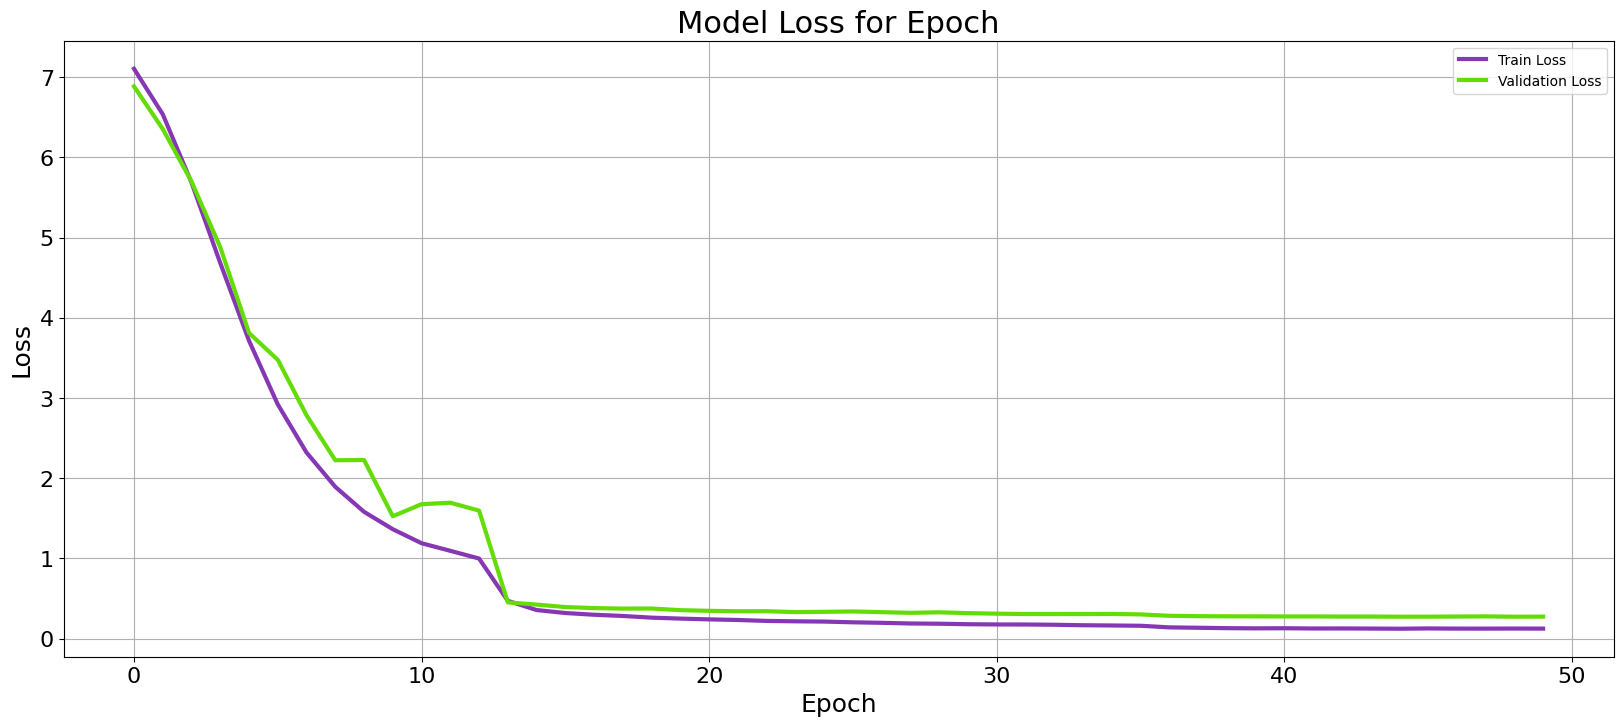

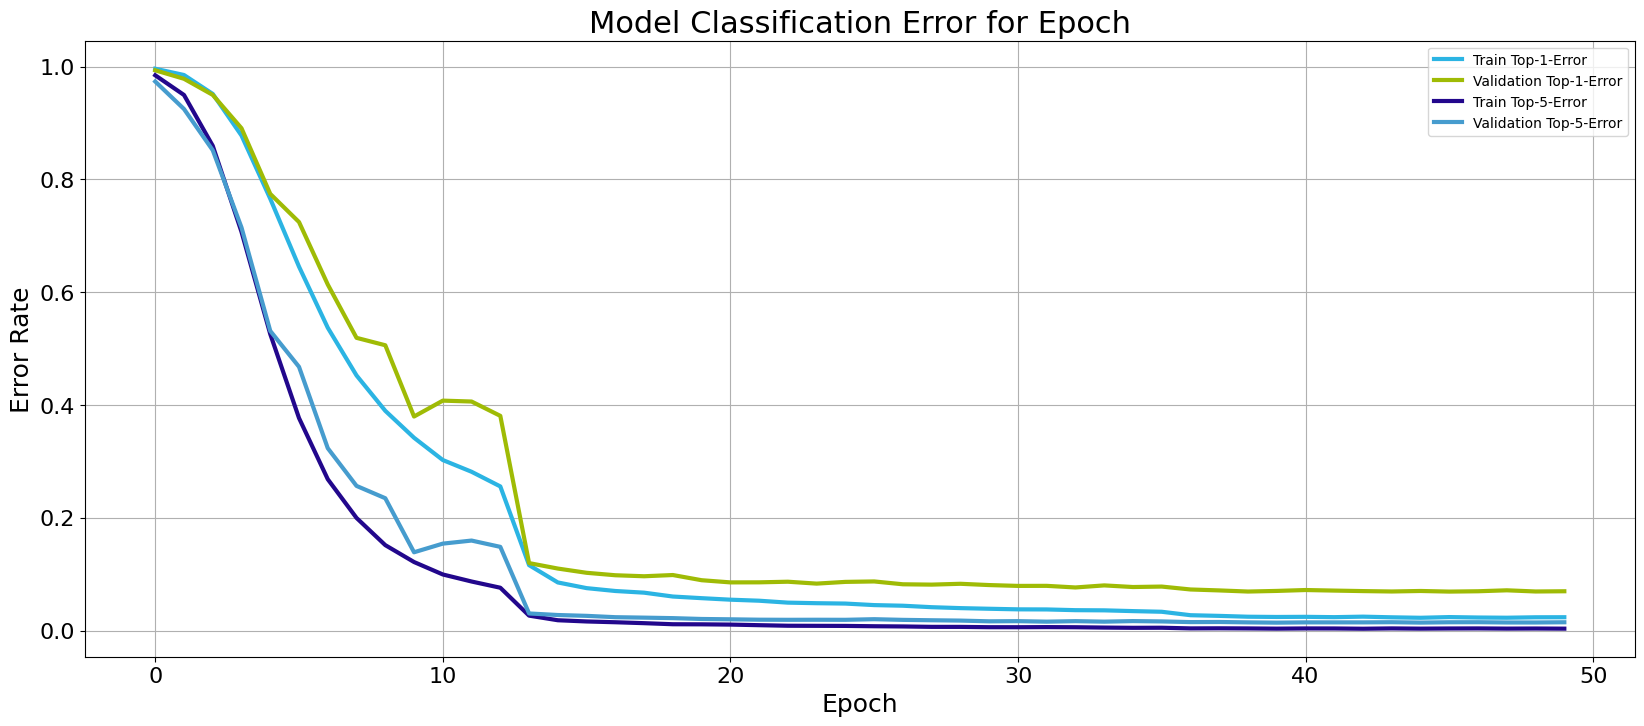

In [12]:
# Plotting the performance of the model in the training and validation phase

plots = [
    (np.arange(0, len(train_losses), 1), train_losses, "Train Loss"),
    (np.arange(0, len(validation_losses), 1), validation_losses, "Validation Loss")
]

show_plot(plots, "Model Loss for Epoch", "Epoch", "Loss")

plots = [
    (np.arange(0, len(train_acc), 1), train_acc, "Train Top-1-Error"),
    (np.arange(0, len(validation_acc), 1), validation_acc, "Validation Top-1-Error"),
    (np.arange(0, len(train_top5_acc), 1), train_top5_acc, "Train Top-5-Error"),
    (np.arange(0, len(validation_top5_acc), 1), validation_top5_acc, "Validation Top-5-Error")
]

show_plot(plots, "Model Classification Error for Epoch", "Epoch", "Error Rate")

## Save Model

In [13]:
MODEL_PATH = './trained_models/' + resnet_type + '_weights_car_'

if params['hierarchy'] == 0:
    MODEL_PATH += 'makers_'
else:
    MODEL_PATH += 'models_'
    
if params['use_train_test_split']:
    MODEL_PATH += 'prepared_dataset_'
else:
    MODEL_PATH += 'full_dataset_'
    
MODEL_PATH += str(params['batch_size']) + '.pth'

torch.save({
    'model_state_dict' : resnet.state_dict(),
    'train_losses': train_losses,
    'train_acc': train_acc,
    'train_top5_acc': train_top5_acc,
    'validation_losses': validation_losses,
    'validation_acc': validation_acc,
    'validation_top5_acc': validation_top5_acc,
    'resnet': params['resnet'],
    }, MODEL_PATH)

# Load and Evaluate Saved Model

## Load

In [14]:
# path to the saved model TO BE CHANGED
MODEL_PATH = './trained_models/model.pth'
saved_model = torch.load(MODEL_PATH)

resnet = ResNet(saved_model['resnet']['block'], saved_model['resnet']['layers'], 
                len(total_set.classes)).to(params['device'])

resnet.load_state_dict(saved_model['model_state_dict'])
train_losses = saved_model['train_losses']
train_acc = saved_model['train_acc']
train_top5_acc = saved_model['train_top5_acc']
validation_losses = saved_model['validation_losses']
validation_acc = saved_model['validation_acc']
validation_top5_acc = saved_model['validation_top5_acc']

FileNotFoundError: [Errno 2] No such file or directory: './trained_models/model.pth'

## Plot performance data

In [ ]:
# Plotting the performance of the model in the training and validation phase

plots = [
    (np.arange(0, len(train_losses), 1), train_losses, "Train Loss"),
    (np.arange(0, len(validation_losses), 1), validation_losses, "Validation Loss")
]

show_plot(plots, "Model Loss for Epoch", "Epoch", "Loss")

plots = [
    (np.arange(0, len(train_acc), 1), train_acc, "Train Top-1-Error"),
    (np.arange(0, len(validation_acc), 1), validation_acc, "Validation Top-1-Error"),
    (np.arange(0, len(train_top5_acc), 1), train_top5_acc, "Train Top-5-Error"),
    (np.arange(0, len(validation_top5_acc), 1), validation_top5_acc, "Validation Top-5-Error")
]

show_plot(plots, "Model Classification Error for Epoch", "Epoch", "Error Rate")